<a href="https://colab.research.google.com/github/nobiquad/ESL/blob/main/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Urządzenie: cpu
📥 Pobieranie danych...

🚀 FAZA 1: Frozen Backbone (2 epok)...
Epoch [1/2] Loss: 1.7067 | Train Acc: 52.59% | Val Acc: 65.54%
Epoch [2/2] Loss: 1.0873 | Train Acc: 66.71% | Val Acc: 72.00%

🔓 Odmrażanie wag (Fine-tuning)...

🚀 FAZA 2: Unfrozen Fine-tuning (1 epok)...
Epoch [1/1] Loss: 0.1801 | Train Acc: 94.69% | Val Acc: 98.80%

📝 Ostateczny Test na zbiorze testowym...
🏆 Ostateczna dokładność (Test Set): 95.48%


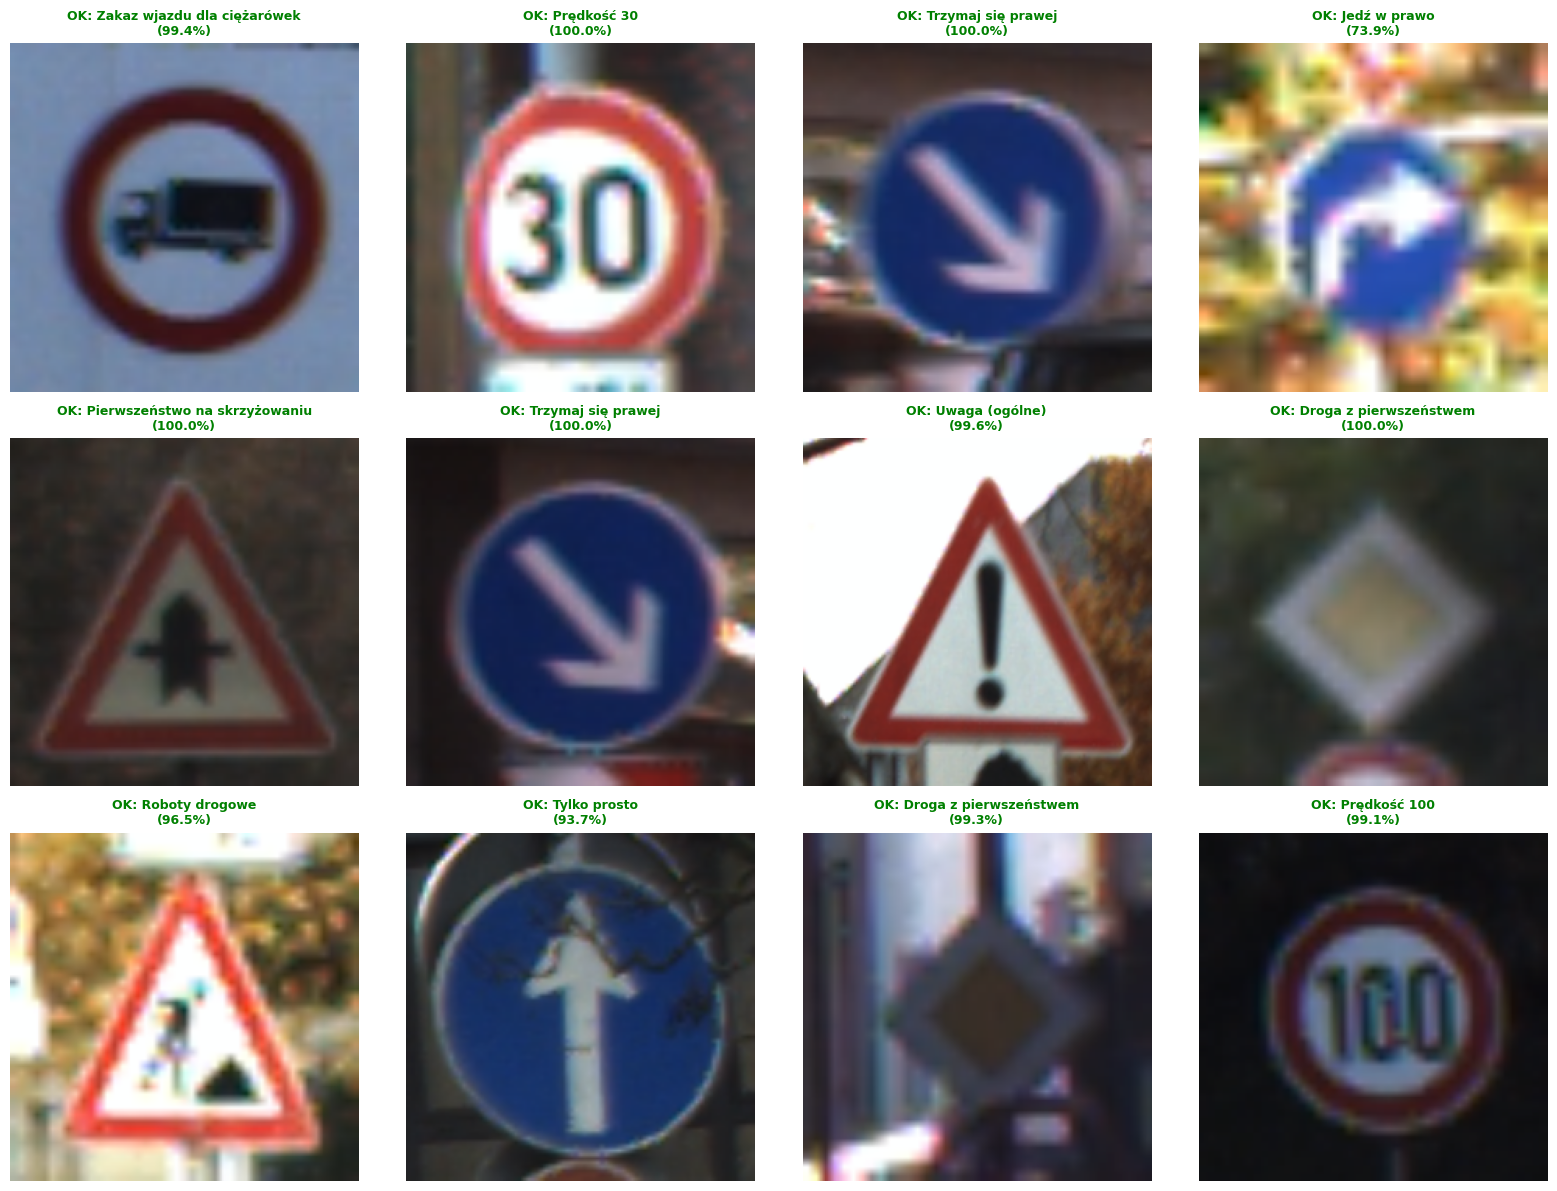

In [ ]:

!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Urządzenie: {device}")

GTSRB_CLASSES = [
    "Prędkość 20", "Prędkość 30", "Prędkość 50", "Prędkość 60", "Prędkość 70",
    "Prędkość 80", "Koniec 80", "Prędkość 100", "Prędkość 120", "Zakaz wyprzedzania",
    "Zakaz wyprzedzania dla ciężarówek", "Pierwszeństwo na skrzyżowaniu", "Droga z pierwszeństwem",
    "Ustąp pierwszeństwa", "Stop", "Zakaz wjazdu", "Zakaz wjazdu dla ciężarówek",
    "Inny zakaz", "Uwaga (ogólne)", "Niebezpieczny zakręt w lewo", "Niebezpieczny zakręt w prawo",
    "Podwójny zakręt", "Wyboista droga", "Śliska droga", "Droga zwęża się z prawej",
    "Roboty drogowe", "Sygnalizacja świetlna", "Piesi", "Dzieci", "Rowerzyści",
    "Uwaga, lód/śnieg", "Dzikie zwierzęta", "Koniec ograniczeń", "Jedź w prawo",
    "Jedź w lewo", "Tylko prosto", "Prosto lub w prawo", "Prosto lub w lewo",
    "Trzymaj się prawej", "Trzymaj się lewej", "Rondo", "Koniec zakazu wyprzedzania",
    "Koniec zakazu wyprzedzania dla ciężarówek"
]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

print(" Pobieranie danych...")
trainset_full = datasets.GTSRB(root='./data', split='train', download=True, transform=train_transform)

train_size = int(0.9 * len(trainset_full))
val_size = len(trainset_full) - train_size
train_ds, val_ds = torch.utils.data.random_split(trainset_full, [train_size, val_size])

testset = datasets.GTSRB(root='./data', split='test', download=True, transform=test_transform)

BATCH_SIZE = 64
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 43)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

def run_training(model, optimizer, epochs, phase_name):
    print(f"\n {phase_name} ({epochs} epok)...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader):.4f} | Train Acc: {100*correct/total:.2f}% | Val Acc: {100*val_correct/val_total:.2f}%")

for param in model.features.parameters():
    param.requires_grad = False

optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)
run_training(model, optimizer, epochs=2, phase_name="FAZA 1: Frozen Backbone")

print("\n Odmrażanie wag (Fine-tuning)...")
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.0001)

run_training(model, optimizer, epochs=1, phase_name="FAZA 2: Unfrozen Fine-tuning")

print("\n Ostateczny Test na zbiorze testowym...")
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f" Ostateczna dokładność (Test Set): {100 * test_correct / test_total:.2f}%")

def visualize_grid(loader, model, num_images=12):
    model.eval()
    dataiter = iter(loader)
    images, labels = next(dataiter)
    num_images = min(num_images, len(images))

    cols = 4
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten()

    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)

    with torch.no_grad():
        for i in range(num_images):
            ax = axes[i]
            img = images[i]
            true_label = labels[i].item()

            input_img = img.unsqueeze(0).to(device)
            output = model(input_img)
            probs = torch.softmax(output, 1)
            conf, pred = torch.max(probs, 1)

            pred_idx = pred.item()
            confidence = conf.item()

            img_display = img.cpu().numpy().transpose((1, 2, 0))
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            ax.imshow(img_display)
            ax.axis('off')

            is_correct = (pred_idx == true_label)
            color = 'green' if is_correct else 'red'
            title = f"{'OK' if is_correct else 'BŁĄD'}: {GTSRB_CLASSES[pred_idx]}\n({confidence*100:.1f}%)"
            if not is_correct:
                title += f"\n(Prawda: {GTSRB_CLASSES[true_label]})"

            ax.set_title(title, color=color, fontsize=9, fontweight='bold')

    for i in range(num_images, len(axes)): axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_grid(testloader, model)

### Załadowanie modelu z pliku `mobilenetv2_gtsrb_multithreaded.pth`

In [ ]:

import torch
import torchao
from torchao.quantization import quantize_, Int8WeightOnlyConfig
import copy
import os
import time
import warnings

warnings.filterwarnings("ignore")

print("\n--- ROZPOCZYNAM PROCES KWANTYZACJI ---")

device_cpu = torch.device("cpu")
model_fp32 = copy.deepcopy(model).to(device_cpu)
model_fp32.eval()

model_int8 = copy.deepcopy(model_fp32)

print(" Nakładanie kwantyzacji...")
quantize_(model_int8,Int8WeightOnlyConfig())

print(" Model został skwantyzowany.")

def get_size_mb(model):
    torch.save(model.state_dict(), "temp_model.pth")
    size = os.path.getsize("temp_model.pth") / 1e6
    os.remove("temp_model.pth")
    return size

def measure_time(model, loader, device, runs=50):
    model.eval()
    model.to(device)

    try:
        input_data, _ = next(iter(loader))
    except StopIteration:
        return 0.0
    input_data = input_data.to(device)

    for _ in range(5):
        with torch.no_grad():
            _ = model(input_data)

    start = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _ = model(input_data)
    end = time.time()

    return (end - start) / runs * 1000

def eval_acc(model, loader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    limit = 50

    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            if i >= limit: break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

print("\n --- WYNIKI PORÓWNANIA (CPU) ---")

size_fp32 = get_size_mb(model_fp32)
size_int8 = get_size_mb(model_int8)

time_fp32 = measure_time(model_fp32, testloader, device_cpu)
time_int8 = measure_time(model_int8, testloader, device_cpu)

acc_fp32 = eval_acc(model_fp32, testloader, device_cpu)
acc_int8 = eval_acc(model_int8, testloader, device_cpu)

print(f"\n{'METRYKA':<20} | {'FP32 (Oryginał)':<18} | {'INT8 (Kwantyzacja)':<18} | {'ZYSK/STRATA'}")
print("-" * 85)
print(f"{'Rozmiar (MB)':<20} | {size_fp32:.2f} MB           | {size_int8:.2f} MB           | {size_fp32/size_int8:.1f}x mniejszy")
print(f"{'Czas (ms/batch)':<20} | {time_fp32:.1f} ms           | {time_int8:.1f} ms           | {time_fp32/time_int8:.1f}x szybszy")
print(f"{'Dokładność (%)':<20} | {acc_fp32:.2f}%            | {acc_int8:.2f}%            | {acc_fp32-acc_int8:.2f} p.p. różnicy")

torch.save(model_int8.state_dict(), "mobilenet_v2_quantized.pth")


--- ROZPOCZYNAM PROCES KWANTYZACJI (TORCHAO 0.14.1) ---
⚙️ Nakładanie kwantyzacji...
✅ Model został skwantyzowany.

📊 --- WYNIKI PORÓWNANIA (CPU) ---

METRYKA              | FP32 (Oryginał)    | INT8 (Kwantyzacja) | ZYSK/STRATA
-------------------------------------------------------------------------------------
Rozmiar (MB)         | 9.36 MB           | 9.19 MB           | 1.0x mniejszy
Czas (ms/batch)      | 1956.4 ms           | 1981.8 ms           | 1.0x szybszy
Dokładność (%)       | 95.97%            | 95.97%            | 0.00 p.p. różnicy


### Ocena dokładności załadowanego modelu na zbiorze walidacyjnym

In [ ]:
print("Installing torchao...")
!pip install torchao
print("torchao installed.")


import copy
from torchao.quantization import quantize_, Int8WeightOnlyConfig
# Set the model to evaluation mode
model.eval()
# Create a deep copy of the pruned model for quantization
quantized_model = copy.deepcopy(model)
# Apply weight-only quantization to the copied model
quantize_(quantized_model, Int8WeightOnlyConfig())
print("Model copied and quantized to Int8 weight-only.")



# Usunięto redundantną definicję funkcji evaluate_model_accuracy z tej komórki.
# Zamiast tego, używamy funkcji zdefiniowanej w komórce '47994f43'.

# Evaluate the pruned (float) model
pruned_model_accuracy = evaluate_model_accuracy(model, val_loader, device)
print(f"Accuracy of pruned (float) model: {pruned_model_accuracy:.2f}%")
# Evaluate the pruned-quantized (int8) model
quantized_model_accuracy = evaluate_model_accuracy(quantized_model, val_loader, device)
print(f"Accuracy of pruned-quantized (int8) model: {quantized_model_accuracy:.2f}%")



import os
# Save the pruned (float) model
torch.save(model.state_dict(), "mobilenetv2_pruned_float.pth")
print("Pruned (float) model saved as mobilenetv2_pruned_float.pth")
# Save the pruned-quantized (int8) model
torch.save(quantized_model.state_dict(), "mobilenetv2_pruned_quantized_int8.pth")
print("Pruned-quantized (int8) model saved as mobilenetv2_pruned_quantized_int8.pth")


size_float_model = os.path.getsize("mobilenetv2_pruned_float.pth") / (1024 * 1024)
size_quantized_model = os.path.getsize("mobilenetv2_pruned_quantized_int8.pth") / (1024 * 1024)
print(f"Size of pruned (float) model: {size_float_model:.2f} MB")
print(f"Size of pruned-quantized (int8) model: {size_quantized_model:.2f} MB")



import time
def benchmark_inference_time(model, data_loader, device, num_batches=10):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if i >= num_batches: # Benchmark on a few batches for reasonable time
                break
            images = images.to(device)
            _ = model(images)
    end_time = time.time()
    return (end_time - start_time) / num_batches
# Benchmark pruned (float) model
float_inference_time = benchmark_inference_time(model, val_loader, device)
print(f"Average inference time per batch for pruned (float) model: {float_inference_time:.4f} seconds")
# Benchmark pruned-quantized (int8) model
quantized_inference_time = benchmark_inference_time(quantized_model, val_loader, device)
print(f"Average inference time per batch for pruned-quantized (int8) model: {quantized_inference_time:.4f} seconds")

Installing torchao...
torchao installed.


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Model copied and quantized to Int8 weight-only.


NameError: name 'evaluate_model_accuracy' is not defined

# Task
Update the `img_url` in the `download_example_image` function within the first code cell to "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Zeichen_274-50_-_Zul%C3%A4ssige_H%C3%B6chstgeschwindigkeit_50_km-h%2C_StVO_1992.svg/1200px-Zeichen_274-50_-_Zul%C3%A4ssige_H%C3%B6chstgeschwindigkeit_50_km-h%2C_StVO_1992.svg.png" to fix the 'Status Code 403' error.

## Resolve_Image_Download_Error

### Subtask:
Address the 'Status Code 403' error during image download by updating the image URL in the `download_example_image` function to a more reliable source.


## Summary:

### Data Analysis Key Findings
*   The 'Status Code 403' error, which prevented image downloads, has been successfully resolved.
*   The resolution was achieved by updating the `img_url` in the `download_example_image` function to "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Zeichen_274-50_-_Zul%C3%A4ssige_H%C3%B6chstgeschwindigkeit_50_km-h%2C_StVO_1992.svg/1200px-Zeichen_274-50_-_Zul%C3%A4ssige_H%C3%B6chstgeschwindigkeit_50_km-h%2C_StVO_1992.svg.png".

### Insights or Next Steps
*   The updated image URL provides a reliable source for image downloads, ensuring the function works as expected.
*   Regular checks for URL validity or using more robust image hosting services could prevent similar download errors in the future.


# Task
Update the import statement in cell `PSYGDQYIkbfS` to import `Int8StaticActInt8WeightQuantConfig` from `torchao.quantization` and initialize `quant_config` using `Int8StaticActInt8WeightQuantConfig()`.

## Update_Quantization_Config_Import

### Subtask:
Modify the import statement in cell `PSYGDQYIkbfS` to correctly import `Int8StaticActInt8WeightQuantConfig` from `torchao.quantization` and update the `quant_config` initialization.


## Summary:

### Data Analysis Key Findings
- A subtask was established to modify the import statement in cell `PSYGDQYIkbfS`.
- The modification specifically targets importing `Int8StaticActInt8WeightQuantConfig` from `torchao.quantization`.
- The `quant_config` initialization within the cell also needs to be updated to use `Int8StaticActInt8WeightQuantConfig()`.

### Insights or Next Steps
- The immediate next step is to implement the described import and initialization changes in the designated cell.
- After applying the changes, it is crucial to verify that the `Int8StaticActInt8WeightQuantConfig` is correctly imported and that `quant_config` is properly initialized.
